# Think Bayes solutions: Chapter 4

This notebook presents solutions to exercises in Think Bayes.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import display
from sympy import symbols
import matplotlib.pyplot as plt
import mythinkbayes as mtb
import numpy as np
import scipy.stats

'Done'

'Done'

## The Euro problem

Here's a class that represents hypotheses about the probability a coin lands heads.

We can make a uniform prior and update it with 140 heads and 110 tails:

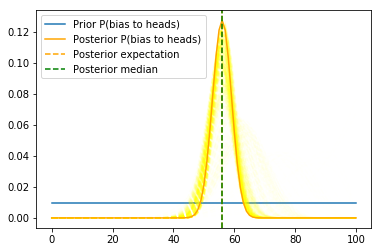

In [2]:
class EuroExample(mtb.PMF):
    
    def likelihood(self, data, hypo):
        """
        data: string 'H' or 'T' indicating how the coin flipped.
        hypo: hypothesized probability of heads, 0-100.
        returns: float likelihood
        """
        # By convention, the PMF specifies the probability of "heads"
        if data == 'H':
            return hypo / 100
        else:
            return 1 - hypo / 100
        
ex = EuroExample(range(0, 101))
plt.plot(ex.index, ex.values, label='Prior P(bias to heads)')


flips = ['H'] * 140 + ['T'] * 110
np.random.shuffle(flips)
for i, flip in enumerate(flips):
    ex.update(flip)
    plt.plot(ex.index, ex.values, color='yellow', linestyle='--', alpha=0.1 * i / len(flips))

plt.plot(ex.index, ex.values, label='Posterior P(bias to heads)', color='orange')
plt.axvline(ex.expectation(), label='Posterior expectation', color='orange', linestyle='--')
plt.axvline(mtb.CDF.from_pmf(ex).percentile(50), label='Posterior median', color='green', linestyle='--')
plt.legend()
plt.show()

We can summarize the posterior several ways, including the mean:

In [3]:
ex.expectation()

55.952380952380956

Median:

In [4]:
mtb.CDF.from_pmf(ex).percentile(50)

56

The peak of the posterior, known as the Maximum Aposteori Probability (MAP)

In [5]:
ex.MAP()

(56, 0.12745318058391109)

And a 90% credible interval

In [6]:
mtb.CDF.from_pmf(ex).interval([5, 95])

[51, 61]

We can look up a particular value in the posterior PMF, but the result doesn't mean much, because we could have divided the range (0-100) into as many pieces as we like, and the result would be different.

In [7]:
ex[50]

0.02097652612954467

## Different priors

Let's see how that looks with different priors.

The results are almost identical; the remaining difference is unlikely to matter in practice.

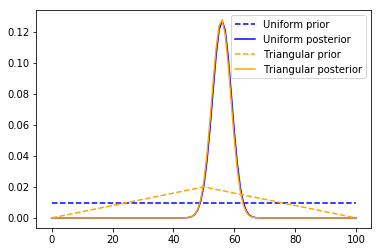

In [8]:
# Same flips for both priors.
flips = ['H'] * 140 + ['T'] * 110
np.random.shuffle(flips)

# Coins with uniform prior
ex_uni = EuroExample(range(0, 101))
plt.plot(ex_uni.index, ex_uni.values, label='Uniform prior', color='blue', linestyle='--')
for flip in flips:
    ex_uni.update(flip)
plt.plot(ex_uni.index, ex_uni.values, label='Uniform posterior', color='blue')

# Coins with triangle prior
X = np.arange(0, 101)
m = np.median(X)
P = np.abs(X - m) - m
ex_tri = EuroExample(X, P)
plt.plot(ex_tri.index, ex_tri.values, label='Triangular prior', color='orange', linestyle='--')
for flip in flips:
    ex_tri.update(flip)
plt.plot(ex_tri.index, ex_tri.values, label='Triangular posterior', color='orange')

plt.legend()
plt.show()

## The binomial likelihood function

We can make the Euro class more efficient by computing the likelihood of the entire dataset at once, rather than one coin toss at a time.

If the probability of heads is p, we can compute the probability of k=140 heads in n=250 tosses using the binomial PMF.

This works by collapsing the loop over `flips` into an exponentiation that muliplies the probability of heads `heads` times and the probability of tails `tails` times.

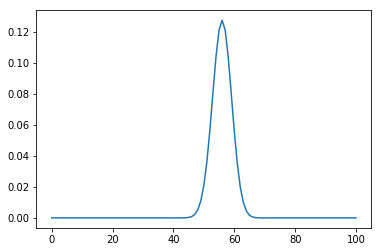

In [9]:
class EuroExampleFaster(mtb.PMF):
    
    def likelihood(self, data, hypo):
        p_heads = (hypo / 100)
        p_tails = 1 - p_heads
        n_heads, n_tails = data
        return p_heads**n_heads * p_tails**n_tails

heads, tails = 140, 110
ex = EuroExampleFaster(range(0, 101))
ex.update((heads, tails))
plt.plot(ex.index, ex.values)
plt.show()

## The Beta distribution

The Beta distribution is a conjugate prior for the binomial likelihood function, which means that if you start with a Beta distribution and update with a binomial likelihood, the posterior is also Beta.

Also, given the parameters of the prior and the data, we can compute the parameters of the posterior directly.  The following class represents a Beta distribution and provides a constant-time Update method.

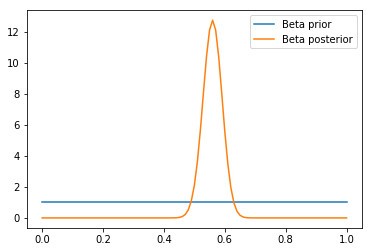

In [10]:
class MyBeta(object):
    
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
    
    def pdf(self, X):
        unnormalized = X ** (self.alpha - 1) * (1 - X) ** (self.beta - 1)
        return unnormalized / unnormalized.sum()
    
    def mean(self):
        return self.alpha / (self.alpha + self.beta)
    
n_heads, n_tails = 140, 110
prior_alpha, prior_beta = 1, 1
X = np.linspace(0, 1, 101)
prior = scipy.stats.beta(prior_alpha, prior_beta)
poste = scipy.stats.beta(prior_alpha + n_heads, prior_beta + n_tails)

plt.plot(X, prior.pdf(X), label='Beta prior')
plt.plot(X, poste.pdf(X), label='Beta posterior')
plt.legend()
plt.show()

## Exercises

**Exercise:** One way to construct priors is to make a Beta distribution and adjust the parameters until it has the shape you want.  Then when you do an update, the data get added to the parameters of the prior.  Since the parameters of the prior play the same mathematical role as the data, they are sometimes called "precounts".

Suppose you believe that most coins are fair or unlikely to deviate from 50% by more than a few percentage points.  Construct a prior that captures this belief and update it with the Euro data.  How much effect does it have on the posterior, compared to the uniform prior?

Hint: A Beta distribution with parameters `(1, 1)` is uniform from 0 to 1.

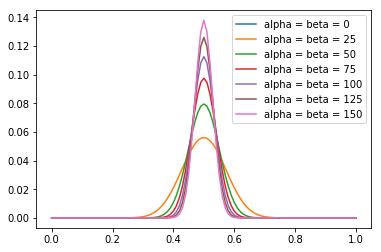

In [11]:
# Notice that the beta distribution converges to the mean as alpha and beta increase.
X = np.linspace(0, 1, 101)
for alpha_beta in np.arange(0, 151, 25):
    P = scipy.stats.beta(alpha_beta, alpha_beta).pdf(X)
    plt.plot(X, P / P.sum(), label='alpha = beta = %d' % alpha_beta)
plt.legend()
plt.show()

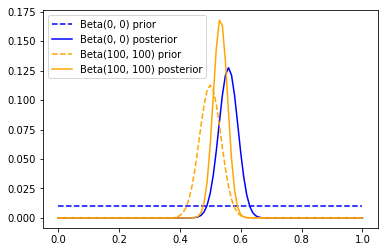

In [12]:
# So if we believe really strongly against unbiased coins,
# we would make the prior a Beta with large values for alpha and beta.
# The plot shows that even with the same updates, the more informative
# prior keeps the posterior closer to a "fair" coin.
n_heads, n_tails = 140, 110
prior_alpha, prior_beta = 50, 50
X = np.linspace(0, 1, 101)


plt.plot(X, MyBeta(1, 1).pdf(X), label='Beta(0, 0) prior', color='blue', linestyle='--')
plt.plot(X, MyBeta(1 + n_heads, 1 + n_tails).pdf(X), label='Beta(0, 0) posterior', color='blue')

plt.plot(X, MyBeta(100, 100).pdf(X), label='Beta(100, 100) prior', color='orange',linestyle='--')
plt.plot(X, MyBeta(100 + n_heads, 100 + n_tails).pdf(X), label='Beta(100, 100) posterior', color='orange')

plt.legend()
plt.show()

**Exercise:**  At the 2016 Summer Olympics in the Women's Skeet event, Kim Rhode faced Wei Meng in the bronze medal match.  They each hit 15 of 25 skeets, sending the match into sudden death.  In the first round, both hit 1 of 2 skeets.  In the next two rounds, they each hit 2 skeets.  Finally, in the fourth round, Rhode hit 2 and Wei hit 1, so Rhode won the bronze medal, making her the first Summer Olympian to win an individual medal at six consecutive summer games.

But after all that shooting, what is the probability that Rhode is actually a better shooter than Wei?  If the same match were held again, what is the probability that Rhode would win?

As always, you will have to make some modeling decisions, but one approach is to estimate, for each shooter, the probability of hitting a skeet.  Then, to estimate the probability that Rhode is a better shooter, you can draw samples from the two posterior distributions and compare them.  To estimate the probability of winning a rematch, you could draw samples from the posterior distributions and simulate a round of 25 shots.

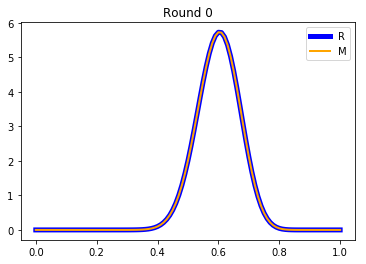

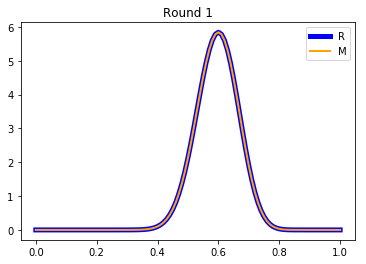

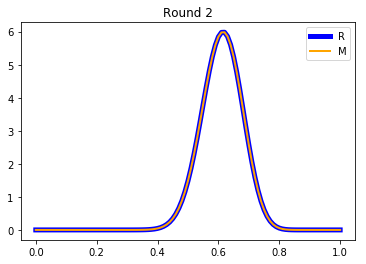

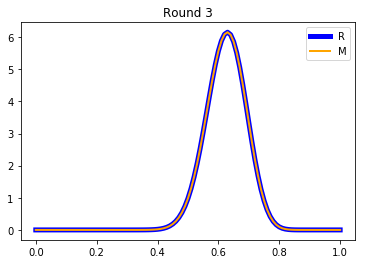

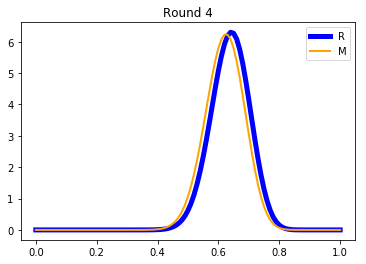

In [13]:
# Variables with suffix _R, and _M represent Rhode and Meng, respectively.

# Both athletes start with alpha=15, beta=10 as a prior
# representing their hits and misses in the match so far.
prm_R = dict(a=15, b=10)
prm_M = prm_R.copy()

# Plot the initial priors.
# Use the same X and colors throughout.
B = scipy.stats.beta
X = np.linspace(0, 1, 101)
plt_R = dict(label='R', color='blue', linewidth=5)
plt_M = dict(label='M', color='orange', linewidth=2)

# The observations used to update the priors are their Hits and Misses in
# each of the sudden death rounds.
obs_R = ['H' * 15 + 'M' * 10, 'HM', 'HH', 'HH', 'HH']
obs_M = ['H' * 15 + 'M' * 10, 'HM', 'HH', 'HH', 'HM']

# Iterate through the rounds and plot each player's updated distribution.
for ri in range(len(obs_R)):
    prm_R['a'] += obs_R[ri].count('H')
    prm_R['b'] += obs_R[ri].count('M')
    prm_M['a'] += obs_M[ri].count('H')
    prm_M['b'] += obs_M[ri].count('M')
    
    plt.plot(X, B(**prm_R).pdf(X), **plt_R)
    plt.plot(X, B(**prm_M).pdf(X), **plt_M)
    plt.title('Round %d' % ri)
    plt.legend()
    plt.show()

In [14]:
# We can estimate the probability that Rhode is a better shooter
# by taking a large sample of games from each players posterior
# and counting how often Rhode has a higher proportion of hits.

rv_R = B(**prm_R)
rv_M = B(**prm_M)

n_shots = 10000
shots_R = rv_R.rvs(n_shots)
shots_M = rv_M.rvs(n_shots)

print(np.mean(shots_R > shots_M))

0.5822


In [15]:
# To estimate the probability of Rhode winning in a rematch,
# we can play many rematches as follows:
# 1. Sample a hit-probability p from each player's posterior.
# 2. Use p to sample a binomial series of 25 shots for each player.
# 3. Count the number of wins, losses, and ties using the sampled shots.

n_games = 10000
n_shots = 25
n_wins = n_loss = n_ties = 0
rv_R = B(**prm_R)
rv_M = B(**prm_M)
for _ in range(n_games):
    shots_R = np.random.binomial(1, rv_R.rvs(), n_shots)
    shots_M = np.random.binomial(1, rv_M.rvs(), n_shots)
    n_wins += sum(shots_R) > sum(shots_M)
    n_loss += sum(shots_R) < sum(shots_M)
    n_ties += sum(shots_R) == sum(shots_M)

print('P(R wins) = %.3lf' % (n_wins / n_games))
print('P(R loses) = %.3lf' % (n_loss / n_games))
print('P(tie) = %.3lf' % (n_ties / n_games))

P(R wins) = 0.500
P(R loses) = 0.403
P(tie) = 0.096


**Exercise** Suppose that instead of observing coin tosses directly, you measure the outcome using an instrument that is not always correct. Specifically, suppose there is a probability `y` that an actual heads is reported as tails, or actual tails reported as heads.

Write a class that estimates the bias of a coin given a series of outcomes and the value of `y`.

How does the spread of the posterior distribution depend on `y`?

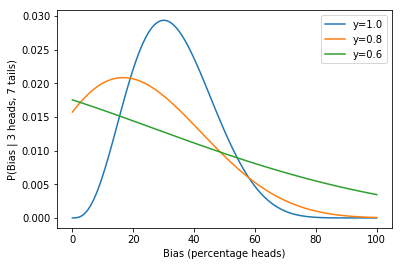

In [16]:
class UnreliableCoin(mtb.PMF):
    
    def likelihood(self, data, hypo):
        """The likelihood returned is a weighted combination of the
        correct and incorrect likelihoods, weighted by their probabilities
        of being correct/incorrect."""
        flip, p_correct = data
        p_wrong = 1 - p_correct
        p_head = hypo / 100.
        p_tail = 1 - p_head
        if flip == 'H':
            return p_head * p_correct + p_tail * p_wrong
        else:
            return p_tail * p_correct + p_head * p_wrong
        

prior = range(0, 101)
n_heads, n_tails = 3, 7
flips = 'H' * n_heads + 'T' * n_tails

for y in [1, 0.8, 0.6]:
    ex = UnreliableCoin(prior)
    for flip in flips:
        ex.update((flip, y))
    
    plt.plot(ex.hypos, ex.probs, label='y=%.1lf' % y)
    
plt.xlabel('Bias (percentage heads)')
plt.ylabel('P(Bias | %d heads, %d tails)' % (n_heads, n_tails))
plt.legend()
plt.show()

**Exercise** This exercise is inspired by a question posted by a “redditor” named dominosci on Reddit’s statistics “subreddit” at http://reddit.com/r/statistics.

Reddit is an online forum with many interest groups called subreddits. Users, called redditors, post links to online content and other web pages. Other redditors vote on the links, giving an “upvote” to high-quality links and a “downvote” to links that are bad or irrelevant.

A problem, identified by dominosci, is that some redditors are more reliable than others, and Reddit does not take this into account.

The challenge is to devise a system so that when a redditor casts a vote, the estimated quality of the link is updated in accordance with the reliability of the redditor, and the estimated reliability of the redditor is updated in accordance with the quality of the link.

One approach is to model the quality of the link as the probability of garnering an upvote, and to model the reliability of the redditor as the probability of correctly giving an upvote to a high-quality item.

Write class definitions for redditors and links and an update function that updates both objects whenever a redditor casts a vote.

In [17]:
class User(mtb.PMF):
    
    def likelihood(self, data, hypo):
        user_quality = hypo
        vote, mean_post_quality = data
        
        if vote == '+':
            return user_quality * mean_post_quality + (1 - user_quality) * (1 - mean_post_quality)
        else:
            return user_quality * (1 - mean_post_quality) + (1 - user_quality) * mean_post_quality
        
class Post(mtb.PMF):
    
    def likelihood(self, data, hypo):
        post_quality = hypo
        vote, mean_user_quality = data
        
        if vote == '+':
            return post_quality * mean_user_quality + (1 - post_quality) * (1 - mean_user_quality)
        else:
            return post_quality * (1 - mean_user_quality) + (1 - post_quality) * mean_user_quality

'Done'         

'Done'

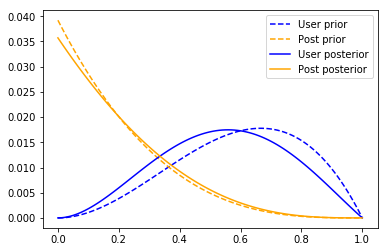

In [18]:
# Example with a single user and a single post.
# With the configuration below, the user's quality gets a little worse
# and the posts quality improves a little. This is reasonable considering
# that the post is more likely to be bad than good, and the user is more
# likely to be good than bad.

# User's quality follows an optimistic Beta prior.
user_X = np.linspace(0, 1, 101)
user_prior = scipy.stats.beta(3, 2).pdf(user_X)
user = User(user_X, user_prior)

# Post's quality is the probability of garnering an upvote.
# I would say most posts on reddit get very few upvotes
# and very few posts get many upvotes.
post_X = np.linspace(0, 1, 101)
post_prior = scipy.stats.beta(1, 4).pdf(post_X)
post = Post(post_X, post_prior)

# Plot priors before update.
plt.plot(user.hypos, user.probs, label='User prior', color='blue', linestyle='--')
plt.plot(post.hypos, post.probs, label='Post prior', color='orange', linestyle='--')

# Update the user and then the post.
user_mean_quality = user.expectation()
post_mean_quality = post.expectation()
user.update(('+', post_mean_quality))
post.update(('+', user_mean_quality))

# Plot posteriors after update.
plt.plot(user.hypos, user.probs, label='User posterior', color='blue')
plt.plot(post.hypos, post.probs, label='Post posterior', color='orange')

plt.legend()
plt.show()

If I have time to return to this, I'd like to figure out:
1. A realistic way to determine whether the user up-votes or down-votes. It doesn't seem realistic to just pick an arbitrary action.
2. An effective way to visualize interactions among multiple users and posts.

In [19]:
'Done'

'Done'